In [1]:
!pip install folium

In [3]:
!pip install prophet

/tmp/ipykernel_164456/2236468555.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Handle missing values


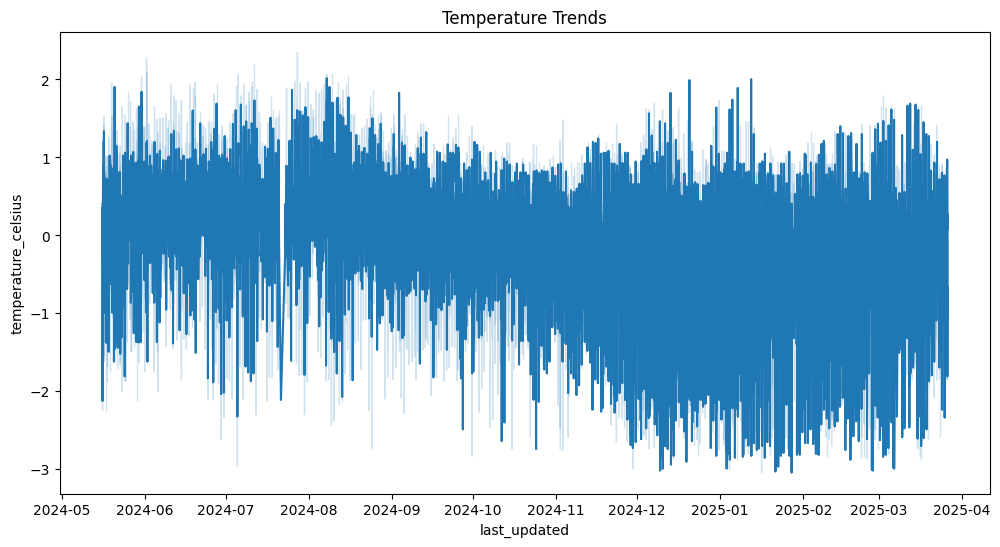

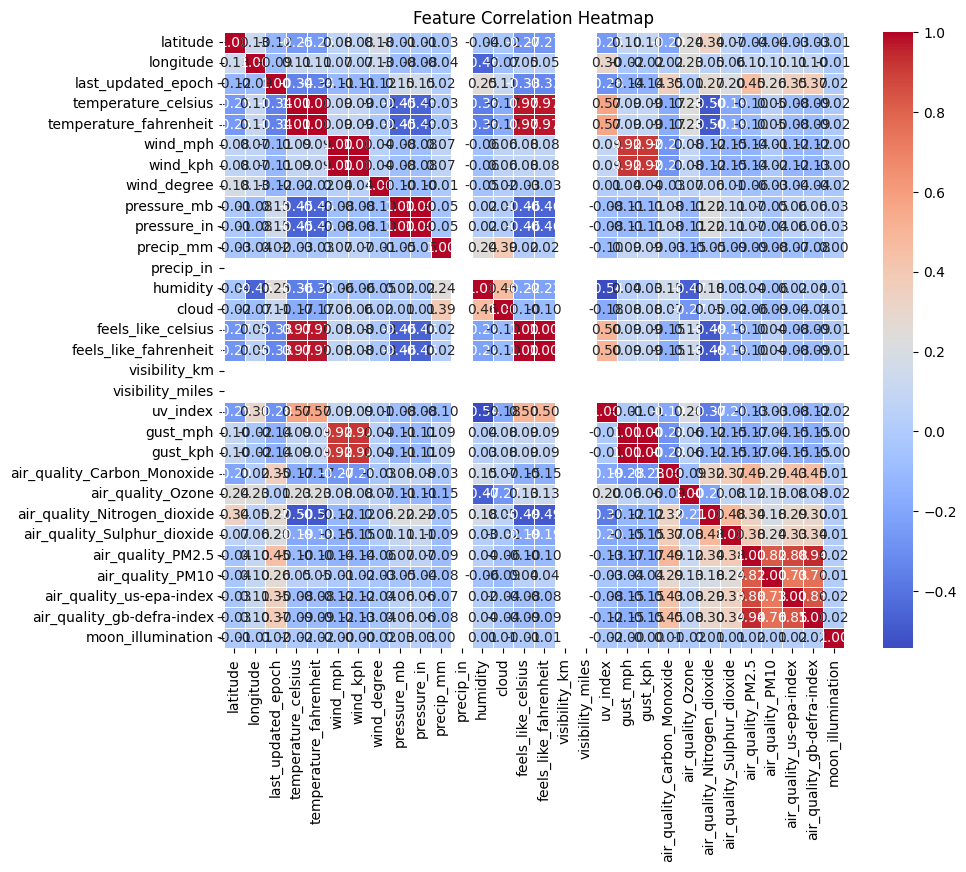

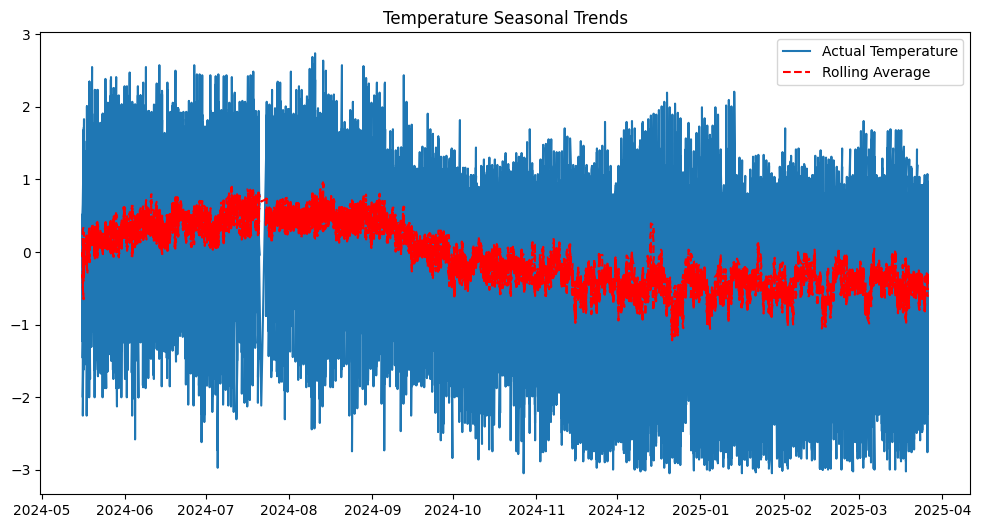

/home/prabhat/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/prabhat/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/prabhat/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/prabhat/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, 

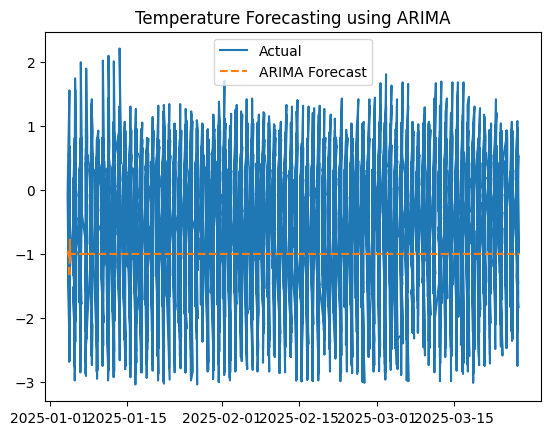

17:15:03 - cmdstanpy - INFO - Chain [1] start processing
17:15:06 - cmdstanpy - INFO - Chain [1] done processing


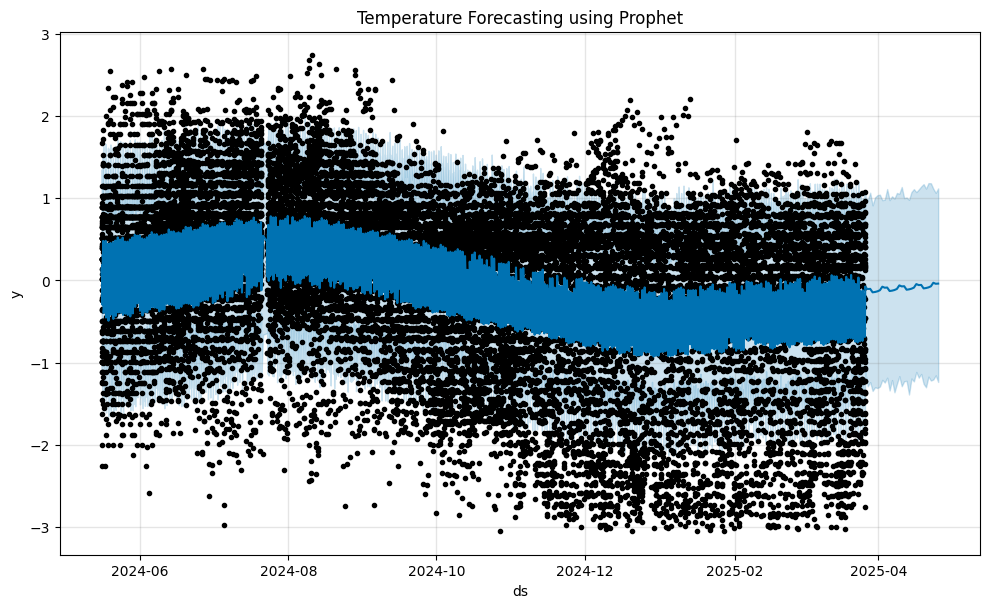

Anomalies:                          country     location_name  latitude  longitude  \
last_updated                                                              
2024-10-27 05:15:00       Canada            Ottawa  1.050837  -1.726818   
2024-12-09 17:00:00       Bhutan           Thimphu  0.349393   1.664986   
2024-12-11 11:45:00       Sweden         Stockholm  1.595168   0.196846   
2024-12-20 11:45:00       Norway              Oslo  1.617987   0.047057   
2024-12-29 13:15:00      Belarus             Minsk  1.382651   0.392120   
2025-01-04 10:45:00      Germany            Berlin  1.328545   0.101432   
2025-01-16 10:15:00      Andorra  Andorra La Vella  0.936754  -0.142402   
2025-01-21 12:30:00    Lithuania           Vilnius  1.413289   0.345952   
2025-01-21 14:00:00         Iran     Chi Chi Khvar  0.692781   0.782460   
2025-01-27 14:00:00         Iran     Chi Chi Khvar  0.692781   0.782460   
2025-01-31 11:30:00      Andorra  Andorra La Vella  0.936754  -0.142402   
2025-02-26 10:

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import folium

# Load dataset
df = pd.read_csv('GlobalWeatherRepository.csv')  # Replace with actual filename

# Data Preprocessing
df.fillna(method='ffill', inplace=True)  # Handle missing values

# Handling outliers using IQR
Q1 = df.select_dtypes(include=['number']).quantile(0.25)
Q3 = df.select_dtypes(include=['number']).quantile(0.75)
IQR = Q3 - Q1
df = df[~((df.select_dtypes(include=['number']) < (Q1 - 1.5 * IQR)).any(axis=1) |
          (df.select_dtypes(include=['number']) > (Q3 + 1.5 * IQR)).any(axis=1))]

# Normalize numerical columns
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Convert datetime features
if 'last_updated' in df.columns:
    df['last_updated'] = pd.to_datetime(df['last_updated'], errors='coerce')
    df.dropna(subset=['last_updated'], inplace=True)
    df.set_index('last_updated', inplace=True)

# Exploratory Data Analysis
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['temperature_celsius'])
plt.title("Temperature Trends")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Rolling Averages for Seasonal Trends
df['rolling_avg'] = df['temperature_celsius'].rolling(window=30, min_periods=1).mean()
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['temperature_celsius'], label='Actual Temperature')
plt.plot(df.index, df['rolling_avg'], label='Rolling Average', linestyle='dashed', color='red')
plt.legend()
plt.title("Temperature Seasonal Trends")
plt.show()

# ARIMA Model
if len(df) > 20:
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    model = ARIMA(train['temperature_celsius'], order=(5, 1, 0))
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))

    plt.plot(test.index, test['temperature_celsius'], label='Actual')
    plt.plot(test.index, predictions, label='ARIMA Forecast', linestyle='dashed')
    plt.legend()
    plt.title("Temperature Forecasting using ARIMA")
    plt.show()

# Prophet Forecasting
df_prophet = df.reset_index()[['last_updated', 'temperature_celsius']].rename(columns={'last_updated': 'ds', 'temperature_celsius': 'y'})
df_prophet.dropna(inplace=True)

model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)
model_prophet.plot(forecast)
plt.title("Temperature Forecasting using Prophet")
plt.show()

# Anomaly Detection using Z-score
df['zscore'] = np.abs((df['temperature_celsius'] - df['temperature_celsius'].mean()) / df['temperature_celsius'].std())
anomalies = df[df['zscore'] > 3]
print("Anomalies:", anomalies)

# Feature Importance using Random Forest
X = df.select_dtypes(include=['number']).drop(columns=['temperature_celsius', 'zscore', 'rolling_avg'], errors='ignore')
y = df['temperature_celsius']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Feature Importance:", rf.feature_importances_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# Geographical Patterns using Clustering
if 'latitude' in df.columns and 'longitude' in df.columns:
    df.dropna(subset=['latitude', 'longitude'], inplace=True)
    map_center = [df['latitude'].mean(), df['longitude'].mean()]
    weather_map = folium.Map(location=map_center, zoom_start=2)

    for _, row in df.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"{row.get('location_name', 'Unknown')} - {row['temperature_celsius']:.2f}°C"
        ).add_to(weather_map)

    weather_map.save("weather_map.html")
    print("Analysis Completed! Open 'weather_map.html' to view spatial analysis.")
